In [110]:
from pyensembl import EnsemblRelease as ensbl
import pandas as pd
import numpy as np
import argparse
import os

## Utility functions

In [119]:
def parseArgs(description = 'Get coverage at different DPs for a given list of genes.'):
    parser = argparse.ArgumentParser(description= description)
    parser.add_argument('-b','--bamfile',required=True,help='input bam file')
    parser.add_argument('-g','--genelistfile',required=True)
    parser.add_argument('-o','--outpath',required=True)
    parser.add_argument('-r','--ref',dest = 'ref',default = '',required = True,type=int,help = 'Reference genome is mandatory since only a list of genames is given and we need to match it inside our bam file')
    parser.add_argument('-v','--vcffile',default = '',required=False,help='input vcf file to be usde for complementary analysis', )
    parser.add_argument('-p','--prefix',dest = 'prefix',default = '',required = False)
    parser.add_argument('-s','--splitBamFile', dest='split', action='store_false',help = 'in next iterations this flag will allow to split the reducedBAM file by chromosomes')
    parser.set_defaults(split=False)

    args = parser.parse_args()
    # MANDATORY ARGUMENTS
    bamfile = args.bamfile
    vcffile = args.vcffile
    outpath = args.outpath
    prefix = args.prefix
    ref = args.ref
    genelistfile = args.genelistfile
    
    #OPTIONAL ARGUMENTS
    split= args.split
    
    return bamfile, vcffile, outpath, prefix, ref, genelistfile, split
    
    
    
def check_ref(ref,outpath):
    if ref not in [19,37,38]:
        print 'please, reference must be one of 19,37,38\n'
        print 'bye'
        quit()
    else:
        if ref == 19:
            print 'using ref hg19, '
        if ref == 37:
            print 'using ref hgrc37'
        if ref == 38:
            print 'using ref hgrc38'
    print ''
    
    if not os.path.isdir(outpath):
        os.system('mkdir %s'%outpath)    

    
    
def get_genelist(genelistfile):
    genes = pd.read_csv(genelistfile,header = None)
    genelist = genes.iloc[:,0].tolist()
    print 'genes read from file:'
    print genelist
    print '\n'

    return genelist
    
    
def test_mode():
    ref = 37
    genelistfile = './test/genelist'
    bamfile = './test/test_chr2_190-192k.bam'
    outpath = './test_output/'
    split = False
    return(ref,genelistfile,bamfile,outpath,split)
    
    
def get_locis(genelist,ref,outpath,write_bedfile = True):
    analyzed_genes = []
    try:
        if (ref == 37)|(ref == 19):
            ensemble_version = 75
    except:
        'You must to install the ensemble version 75, please run \n'        
        'pyensembl install --release 75 --species homo_sapiens \n'
    try:
        if ref == 38:
            ensemble_version = 87
    except:
        'You must to install latest ensemble version (87), please run \n'        
        'pyensembl install --release 87 --species homo_sapiens \n'
        
    data = ensbl(ensemble_version)
    locis = []

    for gen in genelist:
        try:
            loc =  data.loci_of_gene_names(gen)
            locis.append(loc[0].to_dict())
            analyzed_genes.append(gen)
        except:
            print 'warning, gen %s was not found and ignored'%gen
#    return pd.concat(locis)
    print '\n'
    ggenes = analyzed_genes
    locis = pd.DataFrame(locis)
    locis['name'] = ggenes
    locis.rename(columns = {'contig':'chrom'},inplace = True)
    locis['score'] = 0 ## this is only for completness, in order to recognize strand as the right next field
    locis = locis[['chrom','start','end','name','score','strand']]
    
    # write file
    bedfile = outpath+'gene_loci.bed'
    if write_bedfile:
        locis.to_csv(bedfile,sep = '\t',index = False,header = None)
        
    return locis, bedfile, locis.columns


def run_samtools_view(bamfile,bedfile,split=False):
    base = os.path.basename(bamfile).split('.bam')[0]
    #print base
    outbam = outpath + base + '_reduced.bam'
    if not split:
        bedfile = bedfile
        call1 = 'samtools view -bh -L %s %s > %s'%(bedfile,bamfile,outbam)
        #print call1
    status = os.system(call1)    
    if status ==0:
        print 'ok samtools'
    else:
        print 'samtools have failed'
        #quit()

    # get index
    call2 = 'samtools index %s'%(outbam)
    index = os.system(call2)
    if index ==0:
        print 'ok index'
    else:
        print 'index have failed'
        #quit()

    return  outbam
    
#def clean_files(): 
#    rm 

def serie_counting(x):
    return pd.Series({'bp_at_10dp':(x>10).sum(),'bp_at_20dp':(x>20).sum(),'bp_at_30dp':(x>30).sum()})

def run_bedtools_coverage(bam,bed,outpath):
    outcoveragefile = outpath + 'coverage_by_gen.tsv'
    call = 'coverageBed -a %s -b %s > %s'%(bed,bam,outcoveragefile)
    status = os.system(call)
    #print call
    if status ==0:
        print 'ok coveragedBed'
    else:
        print 'coveragedBed have failed'

    results = pd.read_table(outcoveragefile,header = None)
    results.columns = ['chr','start','end','name','score','strand','matched_reads','coverage_dp1','len_gen_bp','rel_coverage_dp1']
    
    
    ### the later approach give us the coverage as the 
    #number of read bases at least ONE time over the total length of our gene of interest
    
    ## in the following I atempt to compute the coverage at different minimal dp levels, namely: at dp= 10, 20, 30
    
    #compute dp per base x gene
    file_by_position = outpath + 'coverage_by_position.txt'
    call2 = 'coverageBed -a %s -b %s -d > %s'%(bed,bam,file_by_position)
    os.system(call2)
    
    bypos = pd.read_csv(file_by_position,sep = '\t',header = None)
    #print bypos.head()
    grouping = bypos.groupby([3])[7].apply(lambda x: serie_counting(x))
    
    res  = grouping.unstack(); 
    #reset index and rename it
    cols = res.columns  #reserve columns
    res.reset_index(inplace = True)
    res.columns = ['name']+list(cols)

    
    ###  merge both analysis
    coverage = pd.merge(results,res, on = 'name')
    
    ### relativise results
    abscols = ['bp_at_10dp','bp_at_20dp','bp_at_30dp']

    relatives = np.round((coverage[abscols].transpose() /coverage['len_gen_bp'].values).transpose(),7)
    coverage[abscols] = relatives
    coverage.to_csv(outcoveragefile,index = False, sep = '\t')

    
    
    return outcoveragefile

In [118]:
#bamfile, vcffile, outpath, prefix, ref, genelistfile, split = parseArgs()    
if(False):
    ref, genelistfile, bamfile, outpath, split = test_mode()

    #check params
    check_ref(ref=ref,outpath = outpath)

    genelist = get_genelist(genelistfile)
    gene_loci , bedfile , locicolumns = get_locis(genelist,ref = ref,outpath=outpath)
        
    reduced_bamfile = run_samtools_view(bamfile,bedfile,split=split)

    #compute coverage by gen along the bamfile
    coverage_file = run_bedtools_coverage(reduced_bamfile,bedfile,outpath)
    
    

using ref hgrc37

genes read from file:
['STAT1', 'HLA-A', 'TP53', 'CANDF7']


warning, gen CANDF7 would be ignored


samtools view -bh -L ./test_output/gene_loci.bed ./test/test_chr2_190-192k.bam > ./test_output/test_chr2_190-192k_reduced.bam
ok samtools
ok index
ok coveragedBed


In [ ]:
if __name__ == "__main__":
    #parse arguments
    bamfile, vcffile, outpath, prefix, ref, genelistfile, split = parseArgs()    

    #check params
    check_ref(ref=ref,outpath = outpath)

    genelist = get_genelist(genelistfile)
    gene_loci , bedfile , locicolumns = get_locis(genelist,ref = ref,outpath=outpath)
        
    reduced_bamfile = run_samtools_view(bamfile,bedfile,split=split)

    #compute coverage by gen along the bamfile
    coverage_file = run_bedtools_coverage(reduced_bamfile,bedfile,outpath)



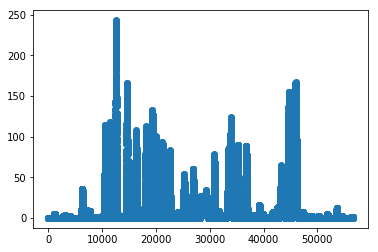

In [42]:
#%matplotlib inline
#from matplotlib import pyplot as plt
#histogr = pd.read_csv('./byposition.txt',sep = '\t',header = None)
#plt.scatter(histogr[6],histogr[7])
#plt.scatter()